/Users/elliott/ej3517/GitHub/FYP_Proprioceptive_Robot_Hand/venv/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ValueError: math domain error

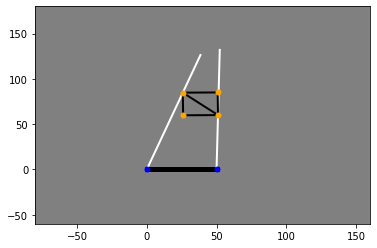

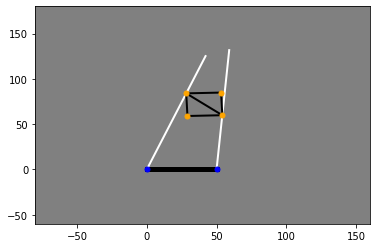

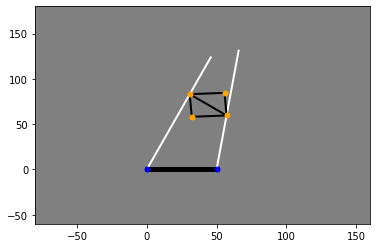

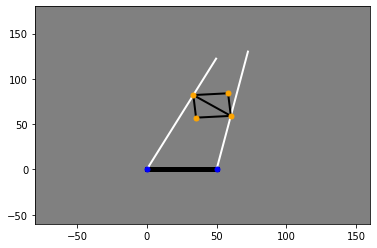

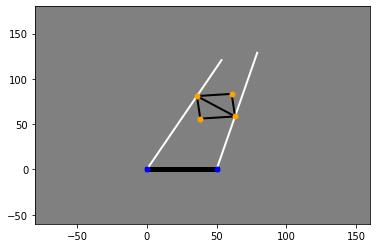

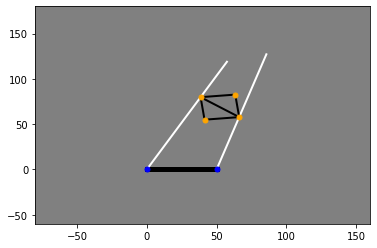

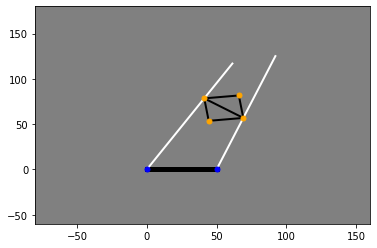

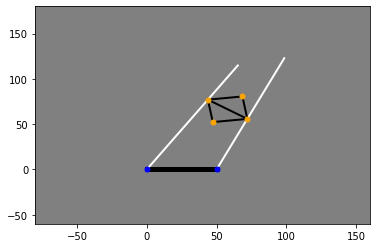

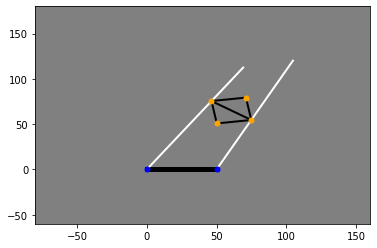

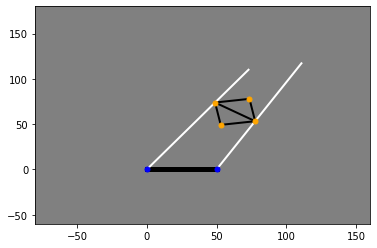

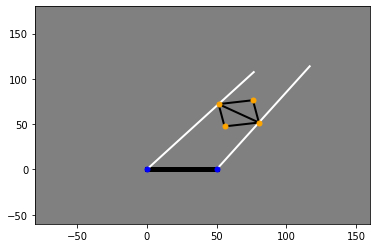

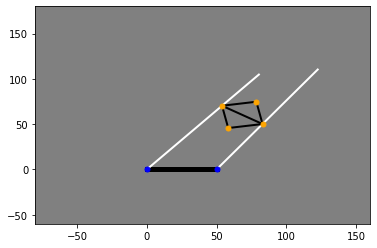

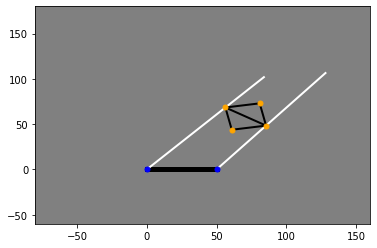

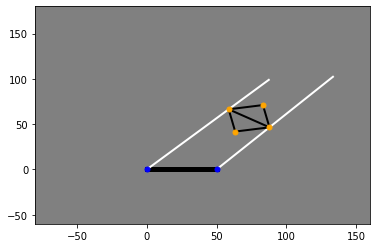

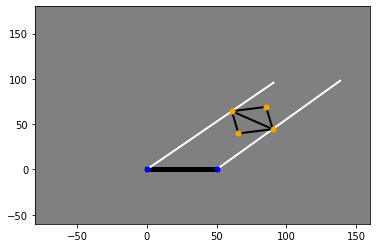

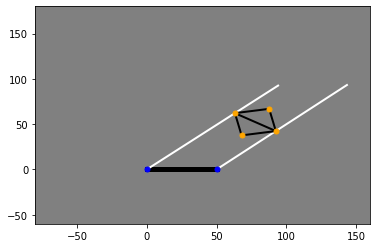

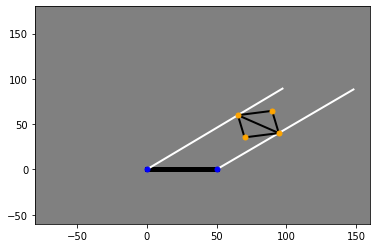

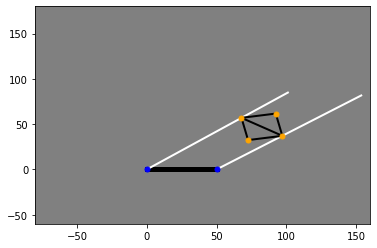

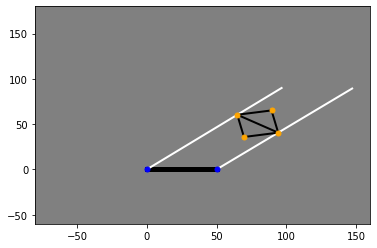

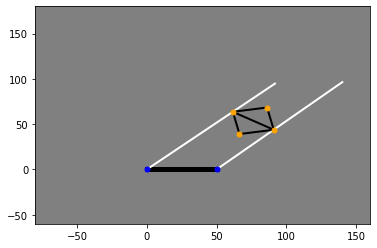

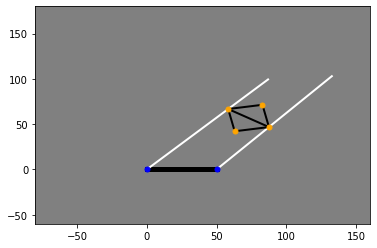

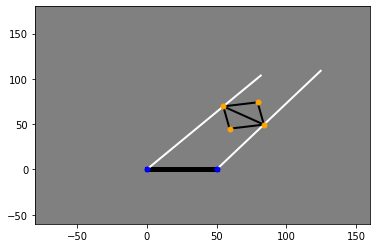

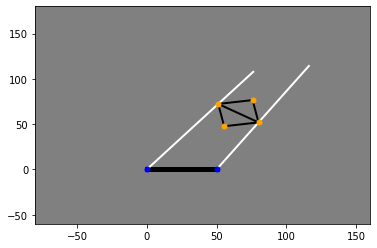

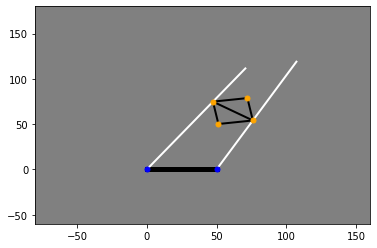

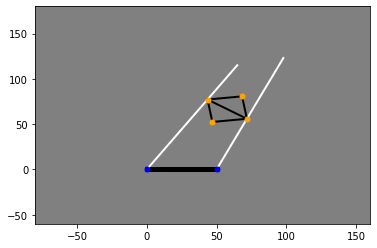

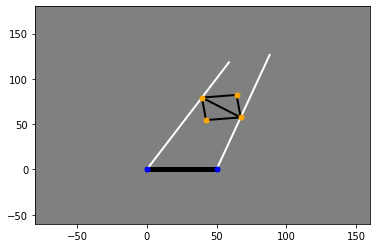

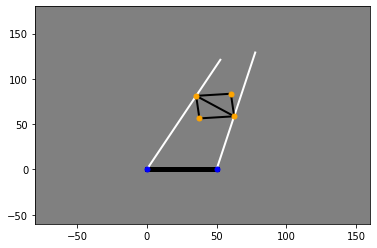

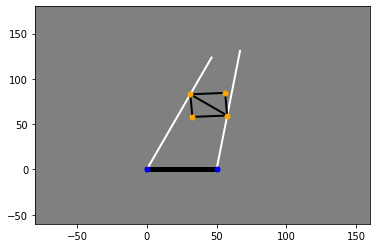

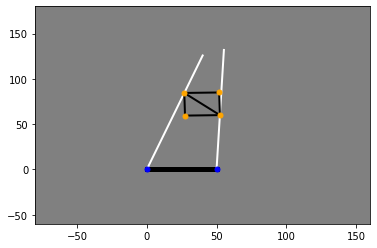

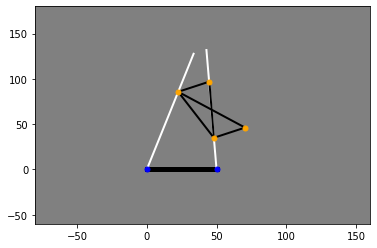

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math


###### trajectory

def pos2deg(ang):
    return int(360/4095.0*ang - 360.0/4)

def deg2pos(angle):
    return int(4095.0/360*angle + 4095.0/4)

def deg2rad(ang):
    return ang*math.pi/180

def list_of_angle(theta1,theta2, increase):
    """ input in deg but output in rad"""
    if increase:
        deg_trajectory = [*range(theta1, theta2, 1)]
    else:
        deg_trajectory = [*range(theta1, theta2, -1)]
    return [element*math.pi/180 for element in deg_trajectory]


########### GEOMETRIC MODEL ############

def norm2points(u,v):
    return math.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)

def model_rolling(theta_lf, a, b, c, d):
    e = math.sqrt(d**2 + a**2 - 2*a*d*math.cos(theta_lf))
    beta = math.acos((e**2 +d**2 - a**2)/(2*d*e))
    delta = math.acos((c**2 +e**2 - b**2)/(2*c*e))
    theta_rf = math.pi - (delta + beta)
    return theta_rf

############## GENERATION OF THE SQUARE
def square_generation(p1,p2,diag):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p2p1 = p2 - p1
    u = p2p1/np.linalg.norm(p2p1)
    ## matrix orthogonal
    T = np.array([[0, -1],[1, 0]])
    ## orthogonal vector
    v = np.matmul(T,u)
    p3 = p1 + (diag/2)*(u+v)
    p4 = p1 + (diag/2)*(u-v)
    return [p3, p4]

def square_generation_side(p1,p2,side,up):
    """ up means that the contact point are the upper side of the square"""
    p1 = np.array(p1)
    p2 = np.array(p2)
    p2p1 = p2 - p1
    u = p2p1/np.linalg.norm(p2p1)
    ## matrix orthogonal
    T = np.array([[0, -1],[1, 0]])
    ## orthogonal vector
    v = np.matmul(T,u)
    if up:
        p3 = p1 - side*v
        p4 = p2 - side*v
    else:
        p3 = p1 + side*v
        p4 = p2 + side*v
    return [p3, p4]


def corner_identification(pivot,p1,p2):
    """ cos(ang) = (p1-pivot).(p2-pivot)/norm"""
    v = np.array(p1) - np.array(pivot)
    u = np.array(p2)- np.array(pivot)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    angle = math.acos(np.dot(v,u)/(norm_u*norm_v))
    return angle > math.pi/2

########### ANIMATION / SIMULATION ##############

def ini_left_contact(face,c,d):
    """calculate the left contact point given that sqaure perpendicular to right finger """
    return math.sqrt((d-face)**2+(c+face)**2)

# create loop for the animation
def rolling_simulation(a, b, c, d, face, traj, forward):
    len_finger = 132
    N = len(traj)
    diagonal = True
    upper_side = True
    for i in range(0,N+1,3):
        theta_pos = traj[0] + i*(traj[-1]-traj[0])/N ### from 2pi/9 to 7pi/9
        A = [0, 0]
        D = [finger_gap, 0]
        if forward:
            theta_pos = math.pi - theta_pos
            theta_follow = model_rolling(theta_pos,c,b,a,d)
            theta_l = math.pi - theta_follow
            theta_r = math.pi - theta_pos
        else:
            theta_follow = model_rolling(theta_pos,a,b,c,d)
            theta_r = theta_follow
            theta_l = theta_pos
        B = [a*math.cos(theta_l), a*math.sin(theta_l)]
        C = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
        ### finger ends
        G = [len_finger*math.cos(theta_l), len_finger*math.sin(theta_l)]
        H = [finger_gap + len_finger*math.cos(theta_r), len_finger*math.sin(theta_r)]

        if diagonal:
            [E, F] = square_generation(B,C, b)
            if corner_identification(C,E,H):
                c = c + face
                C = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
                ### square corners
                [E, F] = square_generation_side(B,C, face, upper_side)
                diagonal = !diagonal
            elif corner_identification(C,F,D):
                c = c - face
                C = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
                ### square corners
                [E, F] = square_generation_side(B,C, face,not upper_side)
                diagonal = !diagonal
            elif corner_identification(B,E,G):
                a = a + face
                B = [a*math.cos(theta_l), a*math.sin(theta_l)]
                ### square corners
                [E, F] = square_generation_side(B,C, face, upper_side)
                diagonal = !diagonal
            elif corner_identification(B,F,A):
                a = a - face
                B = [a*math.cos(theta_l), a*math.sin(theta_l)]
                ### square corners
                [E, F] = square_generation_side(B,C, face, not upper_side)
                diagonal = !diagonal

        else :
            if corner_identification(B,G,C):
                a = a - face
                B = [a*math.cos(theta_l), a*math.sin(theta_l)]
                ### square corners
                [E, F] = square_generation(B,C, face)
                diagonal = !diagonal
            elif corner_identification(B,C,A):
                a = a + face
                B = [a*math.cos(theta_l), a*math.sin(theta_l)]
                ### square corners
                [E, F] = square_generation(B,C, face)
                diagonal = !diagonal
            elif corner_identification(C,B,H):
                c = c - face
                C = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
                ### square corners
                [E, F] = square_generation(B,C, face)
                diagonal = !diagonal
            elif corner_identification(C,B,D):
                c = c + face
                C = [finger_gap + c*math.cos(theta_r), c*math.sin(theta_r)]
                ### square corners
                [E, F] = square_generation(B,C, face)
                diagonal = !diagonal
            elif upper_side:
                ### square corners
                [E, F] = square_generation_side(B,C, face, upper_side)
            elif upper_side:
                ### square corners
                [E, F] = square_generation_side(B,C, face, not upper_side)

        ### plotting ###
        plt.figure()
        ax = plt.axes()
        ax.set_facecolor("gray")
        ### base
        plt.plot([0,finger_gap],[0,0],'black',linewidth=5)
        ### fingers
        plt.plot([A[0],G[0]],[A[1],G[1]],linewidth=2,color='w')
        plt.plot([D[0],H[0]],[D[1],H[1]],linewidth=2,color='w')
        ## square
        plt.plot([B[0],C[0]],[B[1],C[1]],linewidth=2,color='black')
        plt.plot([B[0],E[0]],[B[1],E[1]],linewidth=2,color='black')
        plt.plot([B[0],F[0]],[B[1],F[1]],linewidth=2,color='black')
        plt.plot([C[0],E[0]],[C[1],E[1]],linewidth=2,color='black')
        plt.plot([C[0],F[0]],[C[1],F[1]],linewidth=2,color='black')
        ## pivot
        plt.plot(A[0],A[1],'o',markersize=5,color='blue')
        plt.plot(B[0],B[1],'o',markersize=5,color='orange')
        plt.plot(C[0],C[1],'o',markersize=5,color='orange')
        plt.plot(D[0],D[1],'o',markersize=5,color='blue')
        plt.plot(E[0],E[1],'o',markersize=5,color='orange')
        plt.plot(F[0],F[1],'o',markersize=5,color='orange')
        plt.xlim([-80,160])
        plt.ylim([-60,180])


def manipulation_simulation(sqrt_dim, ini_drf, gap, minang, maxang):
    ## initalisation
    clockwise = True
    anticlockwise = False
    increasing = True
    decreasing = False
    trajectory_increasing = list_of_angle(minang,maxang,increasing)
    trajectory_decreasing = list_of_angle(maxang,minang,decreasing)
    ## geometry
    sqrt_diag = math.sqrt(2)*sqrt_dim # square's diagonal
    drf = ini_drf
    dlf = ini_left_contact(sqrt_dim,ini_drf,gap) # bottom left finger to contact point
    ang90 = deg2rad(90)
    ## first clockwise motion
    trajectory = [element for element in trajectory_decreasing if element < ang90]
    rolling_simulation(dlf, sqrt_diag, drf, finger_gap, sqrt_dim, trajectory, clockwise)
    #### anticlockwise motion
    trajectory = [element for element in trajectory_increasing if element < ang90]
    rolling_simulation(dlf, sqrt_diag, drf, finger_gap, sqrt_dim, trajectory, anticlockwise)

##### initialisation
sqrt_face = 25
initial_drf = 60 # bottom right finger to contact point
finger_gap = 50 # width between fingers
min_ang = 40
max_ang = 140

manipulation_simulation( sqrt_face, initial_drf, finger_gap, min_ang, max_ang)
